# Kaggle - Brain Tumor MRI Dataset

You can find the dataset and some informations about on the [Kaggle page](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset).

For details on steps below, please see documentation in the *docs* directory.

## General part

In [1]:
from pathlib import Path
import ipynbname
import os
import tqdm
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from itertools import combinations
from scipy.stats import norm, levene

In [2]:
NOTEBOOK_PATH = Path(ipynbname.path())
PROJECT_ROOT = Path(NOTEBOOK_PATH).resolve().parents[1]
DATA_DIR = PROJECT_ROOT / "data/raw"

CLASSES = ["notumor", "glioma", "meningioma", "pituitary"]

## EDA

In [3]:
def load_dataset(raw_data_path: Path, dataset_dir: str, classes: list) -> list:
    """
    raw_data_path : path do data raw
    dataset_dir : Training or Testing
    """
    folder_path = raw_data_path / dataset_dir
    dataset = []
    img_files = []
    for class_label in classes:
        class_path = folder_path / class_label
        label_index = classes.index(class_label)
        for img_file in tqdm.tqdm(os.listdir(class_path)):
            if img_file in img_files:
                print("Doublon : {}", img_file)
            else:
                img_files.append(img_file)
            img_path = class_path / img_file
            img = cv2.imread(img_path)
            #img = cv2.resize(img, (224, 224))
            dataset.append((img, label_index))
    return dataset

In [4]:
raw_data = load_dataset(DATA_DIR, "Training", CLASSES)

100%|██████████| 1457/1457 [00:01<00:00, 768.87it/s]


### Shape
#### Images shapes

In [5]:
len(raw_data)

5712

In [6]:
raw_data[0][0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]]], shape=(250, 201, 3), dtype=uint8)

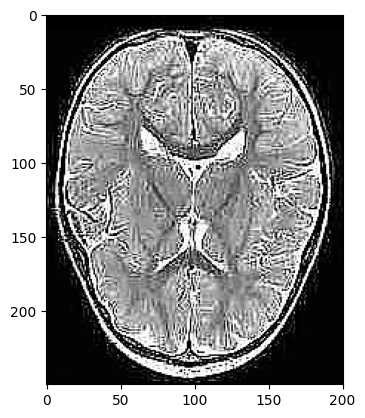

In [7]:
plt.imshow(raw_data[0][0])

In [8]:
cv2.cvtColor(raw_data[0][0], cv2.COLOR_BGR2GRAY)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], shape=(250, 201), dtype=uint8)

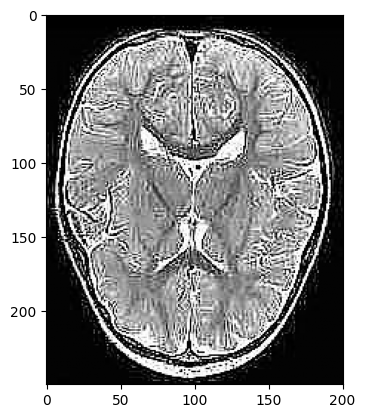

In [9]:
plt.imshow(cv2.cvtColor(raw_data[0][0], cv2.COLOR_BGR2GRAY), cmap='gray')

In [10]:
def count_shape(raw_data):
    shapes = {
        "nb_pix":[],
        "width": [],
        "height": [],
        "colors": [],
        "class": []
             }
    for i in range(0,len(raw_data)):
        dim = raw_data[i][0].shape
        lbl = raw_data[i][1]
        for key, i in zip(shapes.keys(), range(len(shapes.keys()))):
            if i == 0:
                shapes[key].append(dim[0]*dim[1])
            elif i == 4:
                shapes[key].append(lbl)
            else:
                shapes[key].append(dim[i-1])

    return pd.DataFrame.from_dict(shapes)

In [11]:
df_shapes = count_shape(raw_data)

In [12]:
df_shapes.value_counts()

nb_pix   width  height  colors  class
262144   512    512     3       3        1418
                                1        1321
                                2        1199
50625    225    225     3       0         260
396900   630    630     3       0          77
                                         ... 
63736    248    257     3       2           1
63720    270    236     3       0           1
63288    293    216     3       0           1
63248    268    236     3       0           1
2073600  1080   1920    3       0           1
Name: count, Length: 394, dtype: int64

nb_pix
262144    3955
50625      268
396900      77
50400       71
55696       53
          ... 
554400       1
47436        1
224664       1
112671       1
136080       1
Name: count, Length: 368, dtype: int64
width
512    3962
225     277
236      79
630      77
442      72
       ... 
344       1
450       1
781       1
488       1
378       1
Name: count, Length: 230, dtype: int64
height
512    3955
225     270
236     145
630      79
201      73
       ... 
421       1
446       1
237       1
456       1
360       1
Name: count, Length: 199, dtype: int64
colors
3    5712
Name: count, dtype: int64
class
0    1595
3    1457
2    1339
1    1321
Name: count, dtype: int64


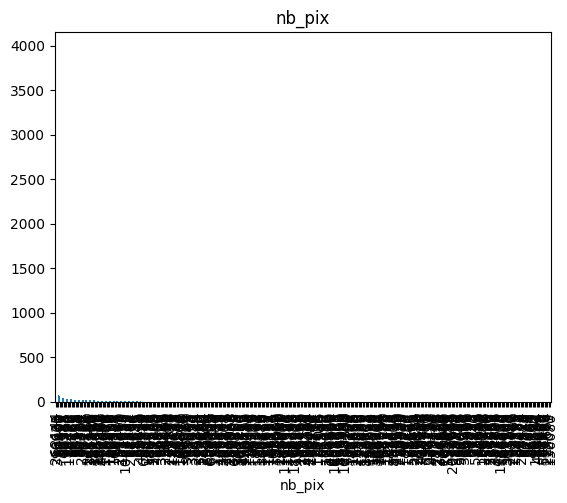

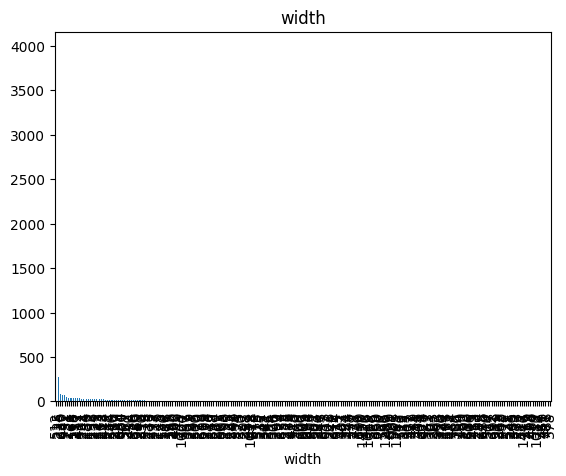

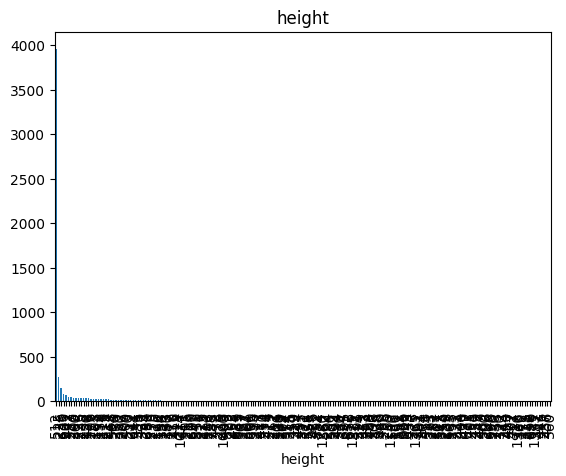

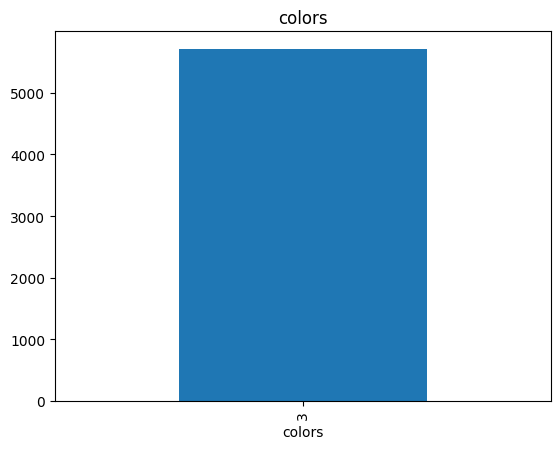

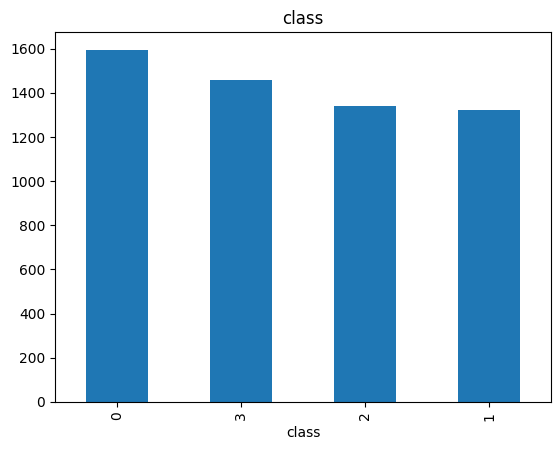

In [13]:
for col in df_shapes.columns:
    plt.figure()
    count = df_shapes[col].value_counts()
    print(count)
    count.plot.bar()
    plt.title(col)

In [14]:
def get_index_by_class(raw_data, classes):
    index_classes = {}
    for c in classes:
        index_classes[c] = []

    for i in range(0, len(raw_data)):
        c = classes[raw_data[i][1]]
        index_classes[c].append(i)

    return index_classes

In [15]:
index_classes = get_index_by_class(raw_data, CLASSES)
#index_classes

### Content

#### Target visualization

In [16]:
def count_label(raw_data, classes):
    count_lbl = {}
    for lbl in classes:
        count_lbl[lbl] = 0

    for i in range(0, len(raw_data)):
        lbl = raw_data[i][1]
        count_lbl[classes[lbl]] += 1

    return count_lbl

In [17]:
count_label(raw_data, CLASSES)

{'notumor': 1595, 'glioma': 1321, 'meningioma': 1339, 'pituitary': 1457}

#### Images orientation

In [18]:
def check_orientation(df_shapes, classes):
    orientation_count = {}
    for elm in (['total'] + classes):
        orientation_count[elm] = {
            'portrait': 0,
            'landscape': 0,
            'square': 0,
        }

    for index, row in df_shapes.iterrows():
        w = row['width']
        h = row['height']
        c = classes[row['class']]
        if h > w:
            orientation = 'portrait'
        elif h < w:
            orientation = 'landscape'
        else:
            orientation = 'square'
        orientation_count['total'][orientation] += 1
        orientation_count[c][orientation] += 1

    return orientation_count

In [19]:
orientation_count = check_orientation(df_shapes, CLASSES)
orientation_count

{'total': {'portrait': 389, 'landscape': 829, 'square': 4494},
 'notumor': {'portrait': 355, 'landscape': 735, 'square': 505},
 'glioma': {'portrait': 0, 'landscape': 0, 'square': 1321},
 'meningioma': {'portrait': 30, 'landscape': 91, 'square': 1218},
 'pituitary': {'portrait': 4, 'landscape': 3, 'square': 1450}}

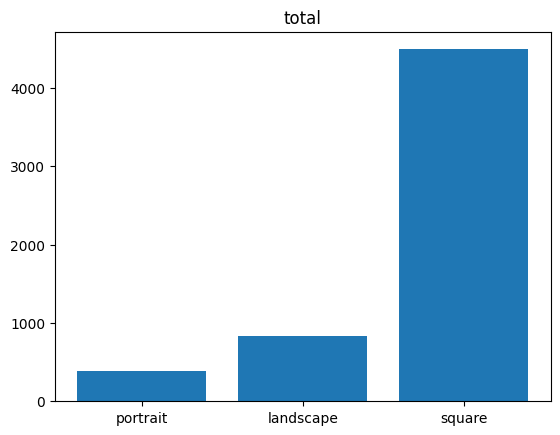

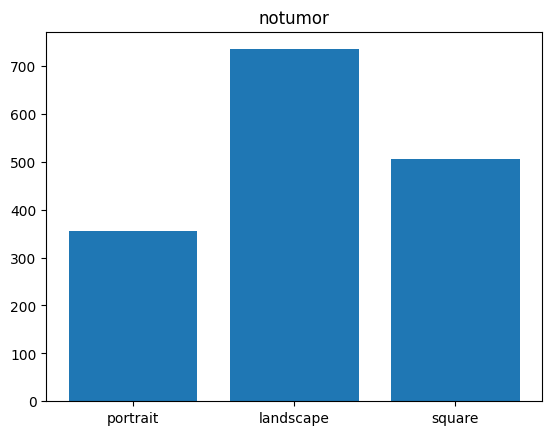

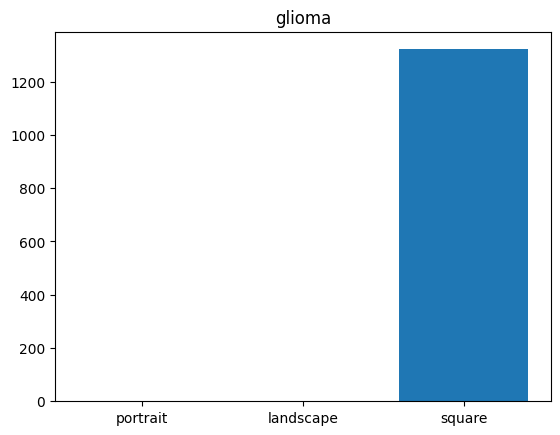

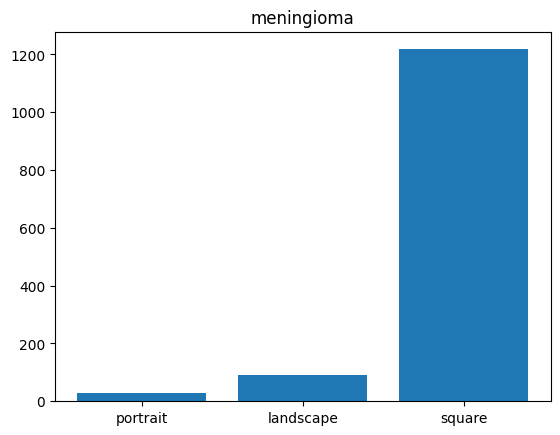

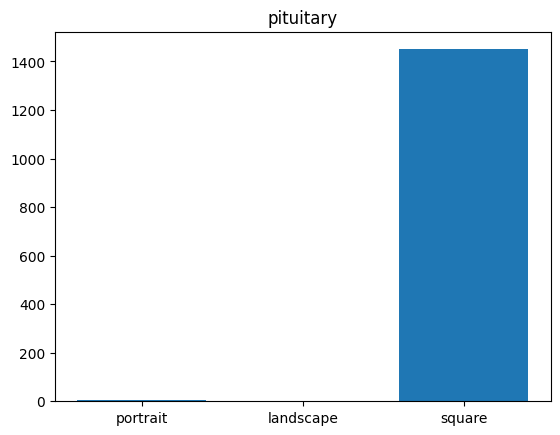

In [20]:
for label in orientation_count:
    plt.figure()
    plt.bar(*zip(*orientation_count[label].items()))
    plt.title(label)

#### Images view

In [21]:
def estimate_MRI_view(df_shapes, classes):
    orientation_count = {}
    for elm in (['total'] + classes):
        orientation_count[elm] = {
            'axial': 0,
            'sagittal': 0,
            'coronal': 0,
        }

    for index, row in df_shapes.iterrows():
        w = row['width']
        h = row['height']
        c = classes[row['class']]
        if h/w > 1.2 :
            orientation = 'sagittal'
        elif h/w < 0.8 :
            orientation = 'coronal'
        else:
            orientation = 'axial'
        orientation_count['total'][orientation] += 1
        orientation_count[c][orientation] += 1

    return orientation_count

In [22]:
view_count = estimate_MRI_view(df_shapes, CLASSES)
view_count

{'total': {'axial': 5448, 'sagittal': 103, 'coronal': 161},
 'notumor': {'axial': 1350, 'sagittal': 95, 'coronal': 150},
 'glioma': {'axial': 1321, 'sagittal': 0, 'coronal': 0},
 'meningioma': {'axial': 1322, 'sagittal': 7, 'coronal': 10},
 'pituitary': {'axial': 1455, 'sagittal': 1, 'coronal': 1}}

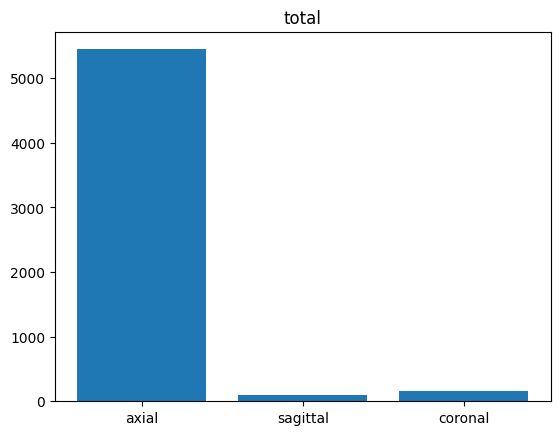

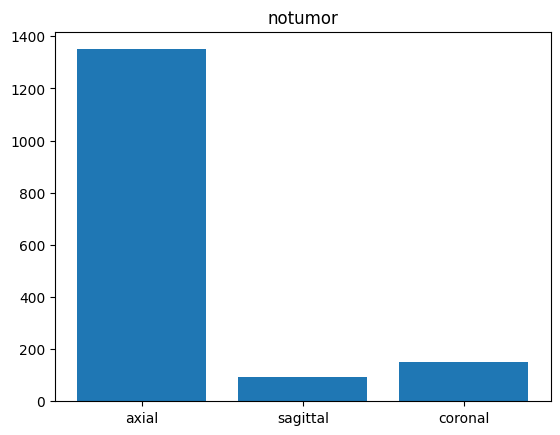

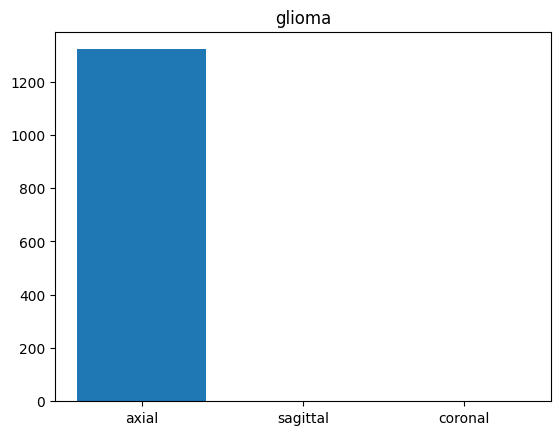

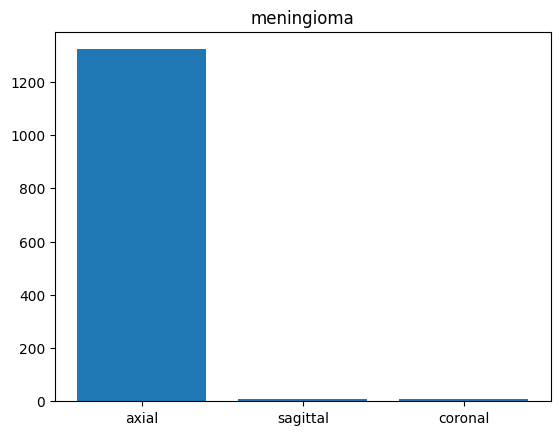

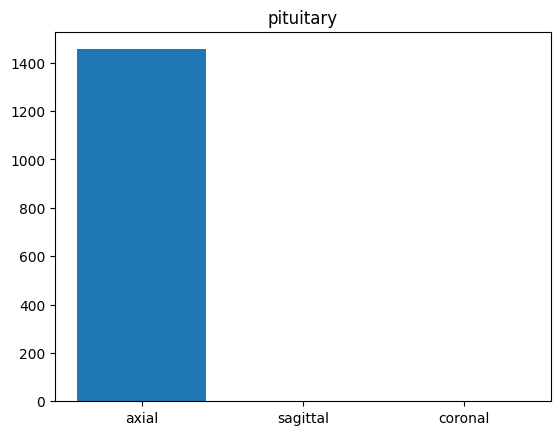

In [23]:
for label in view_count:
    plt.figure()
    plt.bar(*zip(*view_count[label].items()))
    plt.title(label)

#### Images intensity

In [24]:
def compute_intensity_stats(raw_data, classes):
    records = []

    for i in range(0,len(raw_data)):
        img = cv2.cvtColor(raw_data[i][0], cv2.COLOR_BGR2GRAY)  # grayscale
        mean = img.mean()
        std = img.std()
        min_val = img.min()
        max_val = img.max()

        records.append({
            "class": classes[raw_data[i][1]],
            "mean": mean,
            "std": std,
            "min": min_val,
            "max": max_val
        })

    return pd.DataFrame(records)

In [74]:
df_intensity = compute_intensity_stats(raw_data, CLASSES)
df_intensity

,class,mean,std,min,max
0,notumor,104.159644,83.474388,0,209
1,notumor,91.948327,70.375906,0,209
2,notumor,53.709395,46.645536,0,209
3,notumor,120.147107,54.095210,0,209
4,notumor,72.641478,65.517165,0,209
...,...,...,...,...,...
5707,pituitary,53.271942,41.250066,0,209
5708,pituitary,53.533229,43.363209,0,209
5709,pituitary,53.214068,38.224710,0,209
5710,pituitary,61.878585,47.033101,0,209


In [75]:
df_intensity_raw = df_intensity.copy(deep=True)

In [26]:
def detect_brightness_outliers(df, z_thresh=2.576):
    """
    Outliers are detected based on the average brightness.
    z_thresh: threshold in standard deviation
    """
    mu = df["mean"].mean()
    sigma = df["mean"].std()
    df["zscore"] = (df["mean"] - mu) / sigma
    
    return df[(df["zscore"].abs() > z_thresh)]

In [27]:
df_brightness = detect_brightness_outliers(df_intensity)
df_brightness

,class,mean,std,min,max,zscore
0,notumor,108.471164,93.001929,0,255,3.463690
3,notumor,120.912172,57.199174,0,255,4.167923
42,notumor,96.171753,77.672590,0,255,2.767472
82,notumor,101.820742,50.273700,29,255,3.087237
83,notumor,97.030121,79.925613,0,255,2.816060
...,...,...,...,...,...,...
4105,meningioma,93.825469,75.990780,0,255,2.634658
4114,meningioma,104.109175,60.835063,18,255,3.216776
4134,meningioma,93.113179,39.650765,32,255,2.594339
4213,meningioma,108.115605,87.363928,0,255,3.443563


In [28]:
def plot_outliers_histo(df_outliers, classes):
    res = {}
    for elm in classes:
        tmp = df_outliers[df_outliers['class'] == elm]
        res[elm] = len(tmp.index)

    plt.figure()
    bar_cntnr = plt.bar(*zip(*res.items()))
    plt.bar_label(bar_cntnr, label=res.values())

    return res


def plot_outliers_ratio(df_outliers, classes, df_intensity):
    res = plot_outliers_histo(df_outliers, classes)

    for elm in res:
        tmp = df_intensity[df_intensity['class'] == elm]
        total = len(tmp.index)
        res[elm] = f'{res[elm]}/{total} ({round(res[elm]/total*100, 2)}%)'

    return res

{'notumor': '158/1595 (9.91%)',
 'glioma': '0/1321 (0.0%)',
 'meningioma': '22/1339 (1.64%)',
 'pituitary': '1/1457 (0.07%)'}

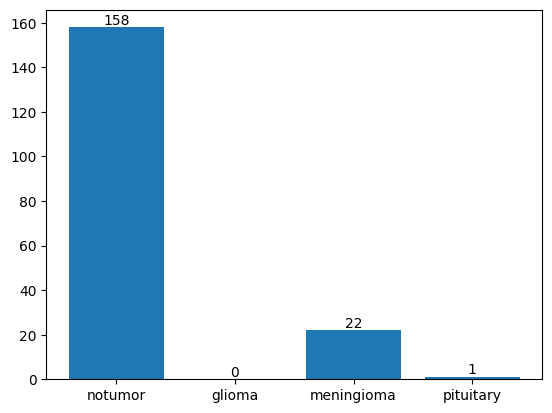

In [29]:
plot_outliers_ratio(df_brightness, CLASSES, df_intensity)

In [30]:
def mean_intensity_per_class(df_intensity):
    df_mi = df_intensity.groupby("class")[["mean", "std"]].mean()    
    return df_mi

def z_test_pairwise(df_intensity, p_thresh=0.05):
    df_mi = mean_intensity_per_class(df_intensity)
    df_mi['n'] = df_intensity.groupby("class")['mean'].count()

    stat_diff = {'class_1':[], 'class_2': [], 'pval': []}
    labels = df_mi.index.to_list()
    for i in range(0, len(labels)):
        for j in range(i+1, len(labels)):
            m1 = df_mi.loc[labels[i],"mean"]
            s1 = df_mi.loc[labels[i],"std"]
            n1 = df_mi.loc[labels[i],"n"]
            m2 = df_mi.loc[labels[j],"mean"]
            s2 = df_mi.loc[labels[j],"std"]
            n2 = df_mi.loc[labels[j],"n"]
            z = (m1-m2) / np.sqrt(s1*s1/n1 + s2*s2/n2)
            pval = norm.sf(abs(z))
            if pval > p_thresh:
                stat_diff['class_1'].append(labels[i])
                stat_diff['class_2'].append(labels[j])
                stat_diff['pval'].append(pval)
                
                
    return df_mi, pd.DataFrame.from_dict(stat_diff)

In [31]:
df_mi, df_diff = z_test_pairwise(df_intensity)

In [32]:
df_mi

,mean,std,n
class,,,
glioma,32.711430,38.325023,1321
meningioma,43.482108,46.733826,1339
notumor,60.723721,60.561156,1595
pituitary,49.267893,41.403495,1457


In [33]:
df_diff

,class_1,class_2,pval


#### Pixel variances per class

In [34]:
def variance_analysis(df):
    return df.groupby("class")["std"].mean()

In [35]:
variance_analysis(df_intensity)

class
glioma        38.325023
meningioma    46.733826
notumor       60.561156
pituitary     41.403495
Name: std, dtype: float64

In [36]:
def pairwise_variance_tests(df):
    classes = df["class"].unique()
    stat_diff = {'class_1':[], 'class_2': [], 'pval': []}
    for c1, c2 in combinations(classes, 2):
        stat, pval = levene(df[df["class"]==c1]["std"],
                               df[df["class"]==c2]["std"])
        stat_diff['class_1'].append(c1)
        stat_diff['class_2'].append(c2)
        stat_diff['pval'].append(pval)

    return pd.DataFrame.from_dict(stat_diff)

In [37]:
pairwise_variance_tests(df_intensity)

,class_1,class_2,pval
0,notumor,glioma,4.604856e-209
1,notumor,meningioma,6.191060e-158
2,notumor,pituitary,5.703957e-273
3,glioma,meningioma,2.413494e-03
4,glioma,pituitary,9.134318e-13
5,meningioma,pituitary,2.808915e-16


Variance differencies are really importants -> need to normalize and crop borders

In [38]:
def show_samples(raw_data, index_classes, classes, samples=None):
    already_sample = True
    if samples == None:
        samples = {}
        already_sample = False
    for cls in classes:
        if not already_sample:
            sample = random.sample(index_classes[cls], 10)
            samples[cls] = sample
        else:
            sample = samples[cls]

        plt.figure(figsize=(12,4))
        for i,i_img in enumerate(sample):
            img = img = raw_data[i_img][0]
            plt.subplot(1,10,i+1)
            plt.imshow(img if img.ndim==2 else cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f'{cls} \nn°{i_img}')
            plt.axis("off")

        
        for i_img in sample:
            img = raw_data[i_img][0]
            plt.imshow(img)
    return samples

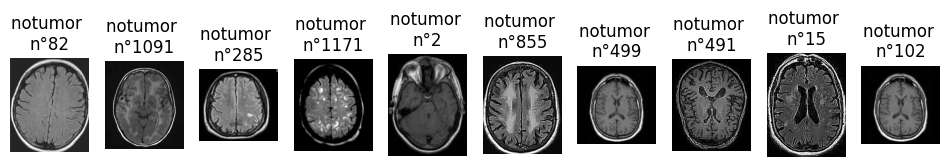

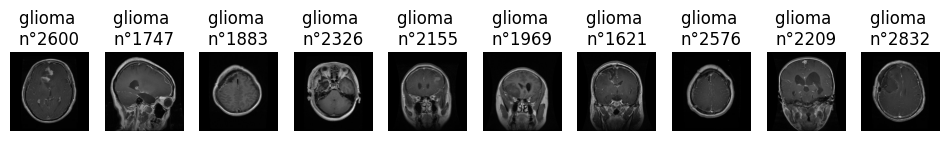

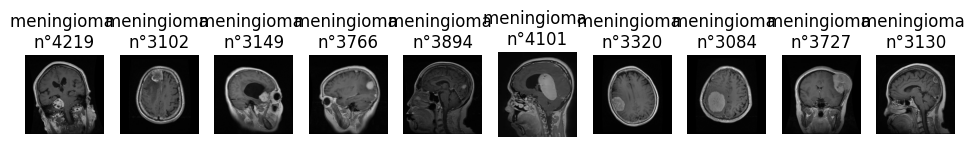

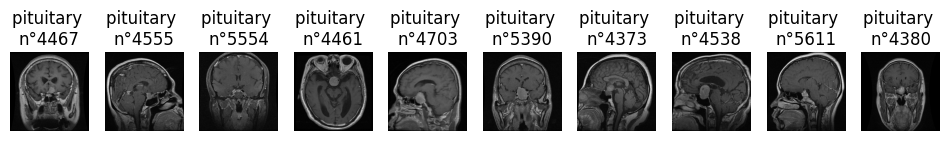

In [39]:
samples_to_keep = show_samples(raw_data, index_classes, CLASSES)

In [40]:
def center_crop(img, crop_ratio=0.7):
    h, w = img.shape[:2]
    new_h, new_w = int(h * crop_ratio), int(w * crop_ratio)
    start_h = (h - new_h) // 2
    start_w = (w - new_w) // 2
    return img[start_h:start_h+new_h, start_w:start_w+new_w]

def crop_black_background(img, thresh=10):
    # 1. Convert to grayscale if needed
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

    # 2. Trouver les pixels > seuil
    mask = gray > thresh
    coords = np.argwhere(mask)  # pixels non noirs

    if coords.size == 0:  # sécurité
        return img

    # 3. Bounding box autour du cerveau
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)

    return img[y0:y1, x0:x1]

def crop_brain_roi(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img
    
    # Flou pour réduire bruit
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Seuillage automatique
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Trouver le plus grand contour
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    biggest = max(contours, key=cv2.contourArea)

    # Rectangle autour du plus gros contour
    x, y, w, h = cv2.boundingRect(biggest)
    return img[y:y+h, x:x+w]

In [41]:
def show_all_crop_methods(img, img_name=""):
    imgs = {
        "original": img,
        "center_crop": center_crop(img),
        "black_crop": crop_black_background(img),
        "roi_crop": crop_brain_roi(img)
    }
    
    plt.figure(figsize=(12,4))
    for i,(name,im) in enumerate(imgs.items()):
        plt.subplot(1,4,i+1)
        plt.imshow(im if im.ndim==2 else cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.title(name + "_" + img_name)
        plt.axis("off")

In [42]:
"""
for cls in CLASSES:
    sample = random.sample(index_classes[cls], 20)
    for i_img in sample:
        img = raw_data[i_img][0]
        show_all_crop_methods(img, cls)
"""

'\nfor cls in CLASSES:\n    sample = random.sample(index_classes[cls], 20)\n    for i_img in sample:\n        img = raw_data[i_img][0]\n        show_all_crop_methods(img, cls)\n'

**Black crop** method is better

In [43]:
for i in tqdm.tqdm(range(0, len(raw_data))):
    raw_data[i] = (crop_black_background(raw_data[i][0]), raw_data[i][1])

100%|██████████| 5712/5712 [00:07<00:00, 727.19it/s] 


In [44]:
def normalize_image(img):
    # Z-score normalisation
    img = (img - np.mean(img)) / np.std(img)
    return img

In [45]:
for i in tqdm.tqdm(range(0, len(raw_data))):
    raw_data[i] = (crop_black_background(raw_data[i][0]), raw_data[i][1])

100%|██████████| 5712/5712 [00:07<00:00, 809.91it/s] 


In [46]:
def get_global_intensity_distrib(raw_data):
    distrib = {}
    for i in tqdm.tqdm(range(0, len(raw_data))):
        unique, counts = np.unique(raw_data[i][0].flatten(), return_counts=True)
        for val, count in zip(unique, counts):
            if val not in distrib:
                distrib[val] = count
            else:
                distrib[val] += count
    return distrib

In [47]:
distrib = get_global_intensity_distrib(raw_data)

100%|██████████| 5712/5712 [00:42<00:00, 134.32it/s]


Text(0.5, 1.0, 'Normalized intensity distribution')

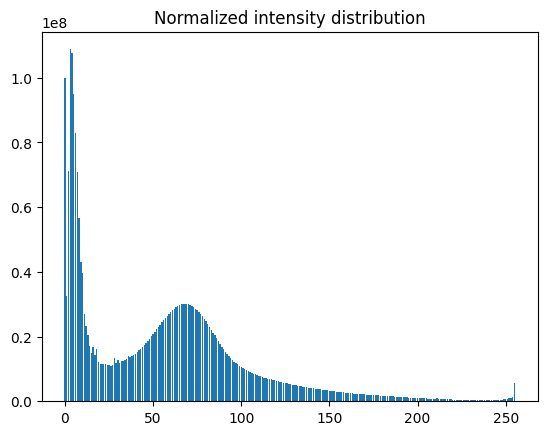

In [48]:
plt.figure()
bar_cntnr = plt.bar(*zip(*distrib.items()))
#plt.bar_label(bar_cntnr, label=res.values())
plt.title("Normalized intensity distribution")

In [49]:
def get_percentiles_from_distrib(distrib, low_bound=0.01, high_bound=0.99):
    pixel_vals = np.array(list(distrib.keys()))
    counts = np.array(list(distrib.values()))
    
    # create a frequency vector (without storing everything)
    frequency_v = np.cumsum(counts) / counts.sum()
    
    # find the p1=1% and p99=99% thresholds
    low_val = pixel_vals[np.searchsorted(frequency_v, low_bound)]
    high_val = pixel_vals[np.searchsorted(frequency_v, high_bound)]
    
    return low_val, high_val

In [50]:
low, high = get_percentiles_from_distrib(distrib)
print(f'{low}, {high}')

0, 209


In [51]:
img_clipped = np.clip(raw_data[0][0], low, high)

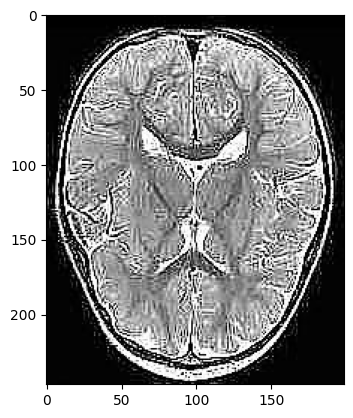

In [52]:
plt.imshow(raw_data[0][0])

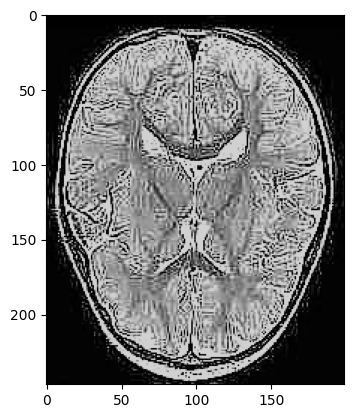

In [53]:
plt.imshow(img_clipped)

In [54]:
def clip_all_images(raw_data, distrib=None, low_bound=0.01, high_bound=0.99):
    if distrib == None:
        distrib = get_global_intensity_distrib(raw_data)
    low, high = get_percentiles_from_distrib(distrib, low_bound, high_bound)
    for i in tqdm.tqdm(range(0, len(raw_data))):
        raw_data[i] = (np.clip(raw_data[i][0], low, high), raw_data[i][1])
    return raw_data, low, high

In [55]:
cliped_data, low, high = clip_all_images(raw_data, distrib=distrib, low_bound=0.01, high_bound=0.99)
print(f'{low}, {high}')

100%|██████████| 5712/5712 [00:02<00:00, 1935.93it/s]

0, 209


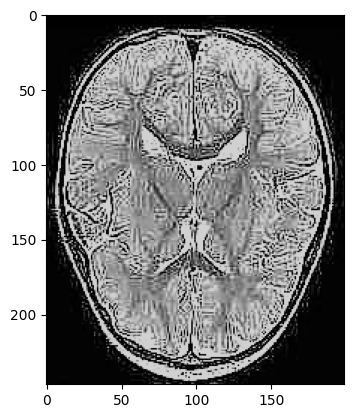

In [85]:
plt.imshow(cliped_data[0][0])

In [78]:
pairwise_variance_tests(df_intensity_raw)

,class_1,class_2,pval
0,notumor,glioma,7.568893e-169
1,notumor,meningioma,2.670485e-129
2,notumor,pituitary,4.866619e-263
3,glioma,meningioma,2.042777e-03
4,glioma,pituitary,1.639547e-24
5,meningioma,pituitary,4.982929e-31


In [79]:
df_intensity_corec = compute_intensity_stats(cliped_data, CLASSES)
pairwise_variance_tests(df_intensity_corec)

,class_1,class_2,pval
0,notumor,glioma,7.568893e-169
1,notumor,meningioma,2.670485e-129
2,notumor,pituitary,4.866619e-263
3,glioma,meningioma,2.042777e-03
4,glioma,pituitary,1.639547e-24
5,meningioma,pituitary,4.982929e-31


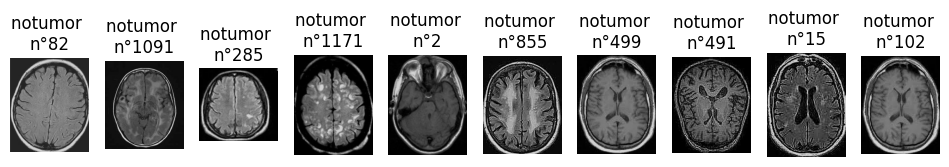

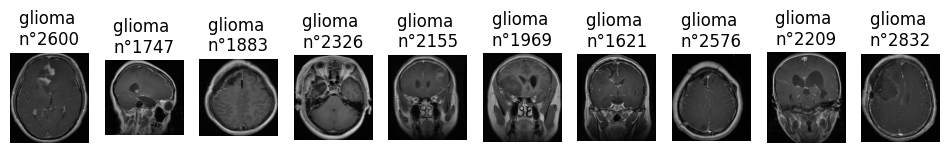

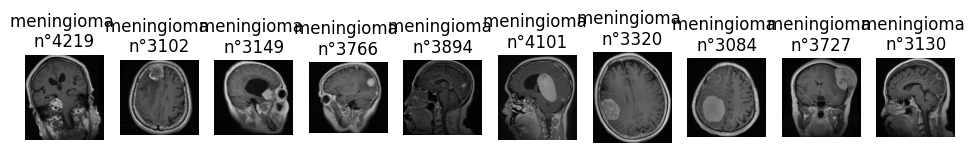

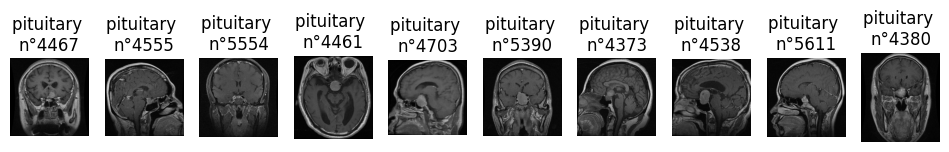

In [58]:
_ = show_samples(raw_data, index_classes, CLASSES, samples=samples_to_keep)

#### Intraclass variability

##### Before cleaning

Text(0.5, 1.0, 'Variance des intensités par classe')

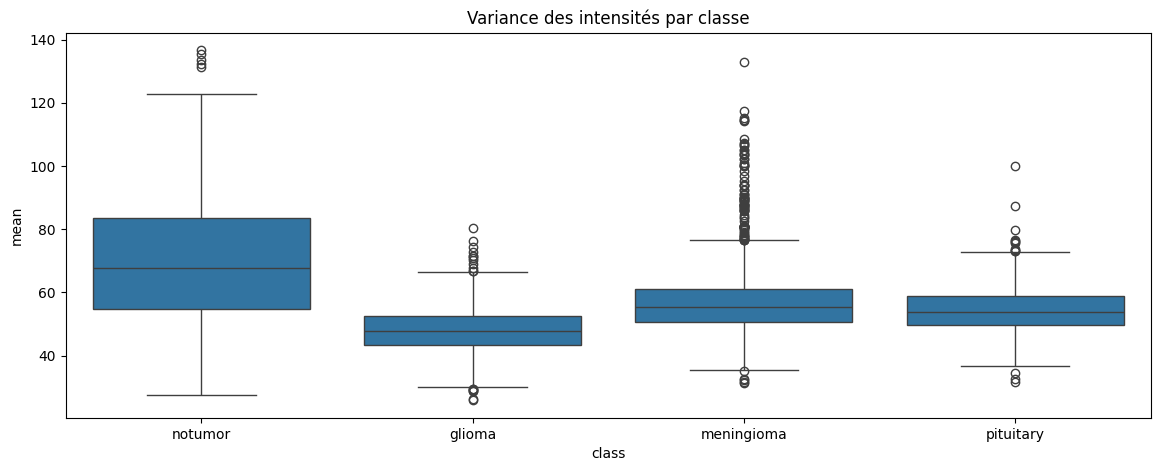

In [80]:
plt.figure(figsize=(14, 5))
sns.boxplot(data=df_intensity_raw, x="class", y="mean")
plt.title("Variance des intensités par classe")
#plt.savefig(PROJECT_ROOT / "tmp_box_plot.png")

Text(0.5, 1.0, 'Distribution intra-classe (mean intensity)')

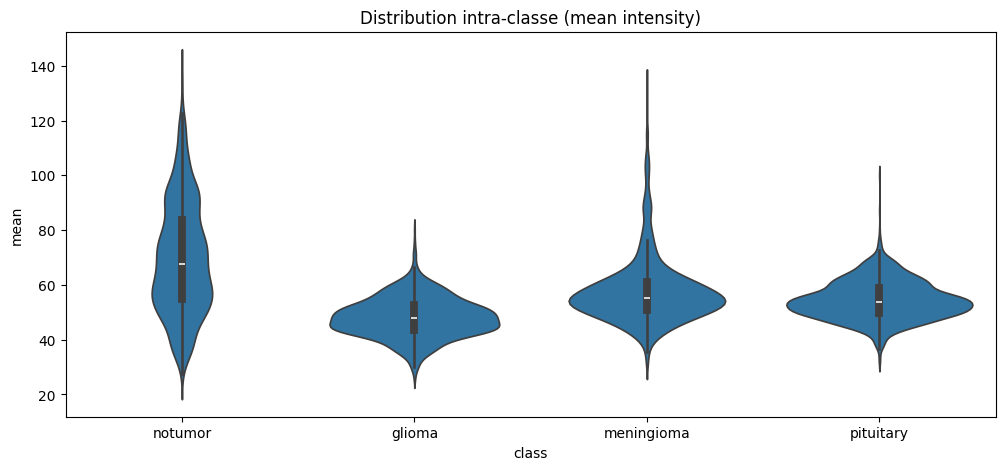

In [81]:
plt.figure(figsize=(12,5))
sns.violinplot(data=df_intensity_raw, x="class", y="mean")
plt.title("Distribution intra-classe (mean intensity)")
#plt.savefig(PROJECT_ROOT / "tmp_violin_plot.png")

##### After cleaning

Text(0.5, 1.0, 'Variance des intensités par classe')

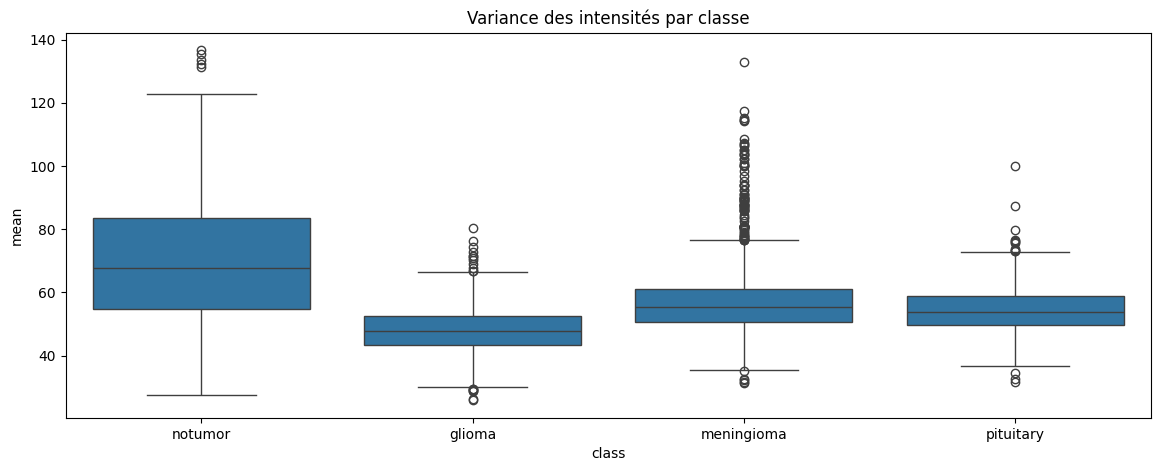

In [82]:
plt.figure(figsize=(14, 5))
sns.boxplot(data=df_intensity_corec, x="class", y="mean")
plt.title("Variance des intensités par classe")
#plt.savefig(PROJECT_ROOT / "tmp_box_plot.png")

Text(0.5, 1.0, 'Distribution intra-classe (mean intensity)')

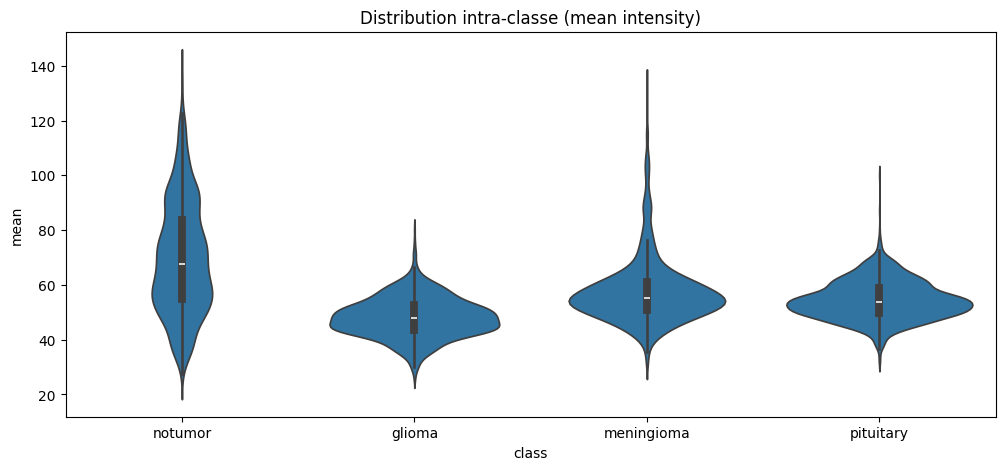

In [83]:
plt.figure(figsize=(12,5))
sns.violinplot(data=df_intensity_corec, x="class", y="mean")
plt.title("Distribution intra-classe (mean intensity)")
#plt.savefig(PROJECT_ROOT / "tmp_violin_plot.png")

##### Outliers

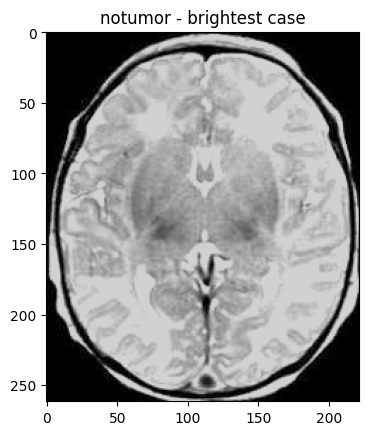

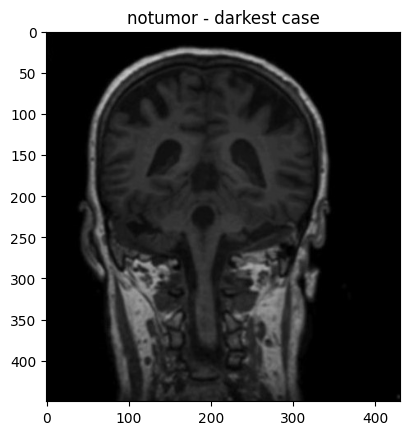

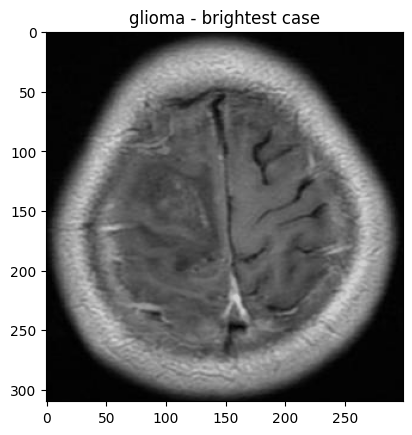

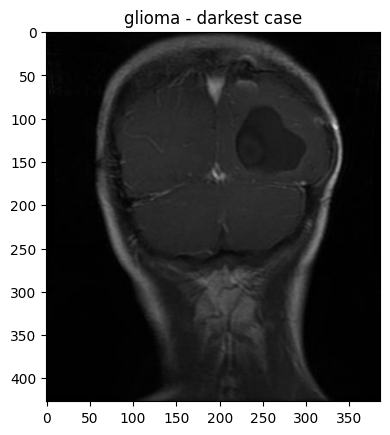

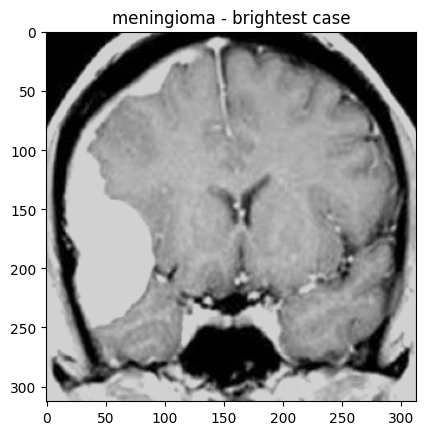

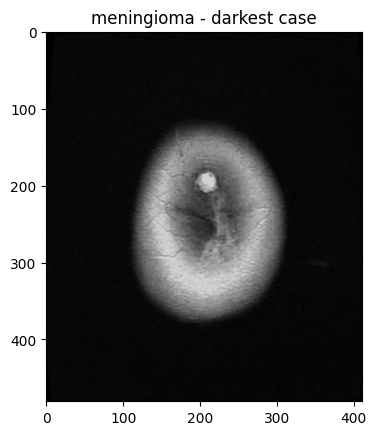

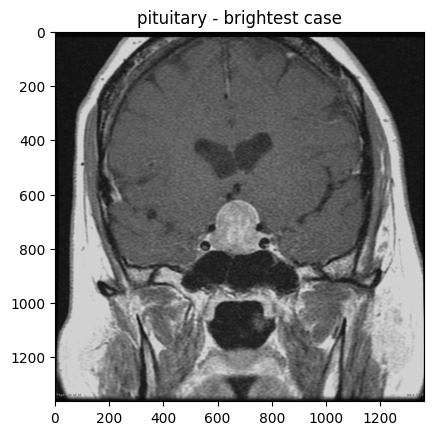

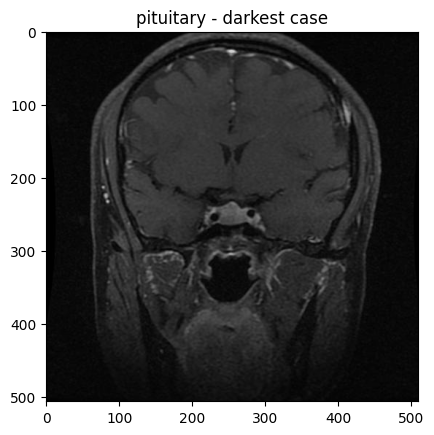

In [94]:
for cls in CLASSES:
    subset = df_intensity_raw[df_intensity_raw["class"] == cls]
    idx_max = subset["mean"].idxmax()
    idx_min = subset["mean"].idxmin()

    plt.figure()
    plt.imshow(raw_data[idx_max][0])
    plt.title(f'{cls} - brightest case')
    plt.figure()
    plt.imshow(raw_data[idx_min][0])
    plt.title(f'{cls} - darkest case')